In [1]:
# Import packages
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm

### Get location IDs to use for query

In [2]:
BASE_URL_LOCATION = "https://www.metaweather.com/api/location/search/?query="

In [3]:
cities = {
    "San Francisco": None,
    "Seoul": None,
    "Chennai": None,
    "Cape Town": None
}

In [4]:
for city in cities.keys():
    payload = requests.get(BASE_URL_LOCATION + city.lower().replace(" ", "+")).json()
    cities[city] = payload[0]["woeid"]

In [5]:
cities

{'San Francisco': 2487956,
 'Seoul': 1132599,
 'Chennai': 2295424,
 'Cape Town': 1591691}

### Get weather for the different locations

In [6]:
BASE_URL_WEATHER = "https://www.metaweather.com/api/location/"

In [7]:
curr_weather = []

for city, woe_id in cities.items():
    payload = requests.get(BASE_URL_WEATHER + str(woe_id)).json()
    curr_weather.append(
        {
            "time_utc": payload["consolidated_weather"][0]["created"],
            "location": city,
            "temperature_c": payload["consolidated_weather"][0]["the_temp"],
            "weather_state": payload["consolidated_weather"][0]["weather_state_name"]
        }
    )

In [8]:
pd.DataFrame(curr_weather)

,time_utc,location,temperature_c,weather_state
0,2022-01-21T00:59:16.170250Z,San Francisco,15.595,Clear
1,2022-01-21T01:09:37.169183Z,Seoul,0.985,Light Cloud
2,2022-01-20T23:34:40.766396Z,Chennai,27.940,Heavy Cloud
3,2022-01-21T00:06:14.545005Z,Cape Town,28.095,Clear


### Load and Append to DataFrame

In [9]:
try:
    df = pd.read_csv("weather_locations.csv")
    df = df.append(pd.DataFrame(curr_weather))
except Exception:
    # Create DataFrame on first run
    df = pd.DataFrame(curr_weather)
    
# Drop duplicate rows
df = df.drop_duplicates()
    
# Save new CSV
df.to_csv("weather_locations.csv", index=False)

### Dynamically Load Font `Lato`

In [10]:
font_path = "./fonts/Lato-Regular.ttf"

fm.fontManager.addfont(font_path)
fm.FontProperties(fname=font_path)

### Plot Data

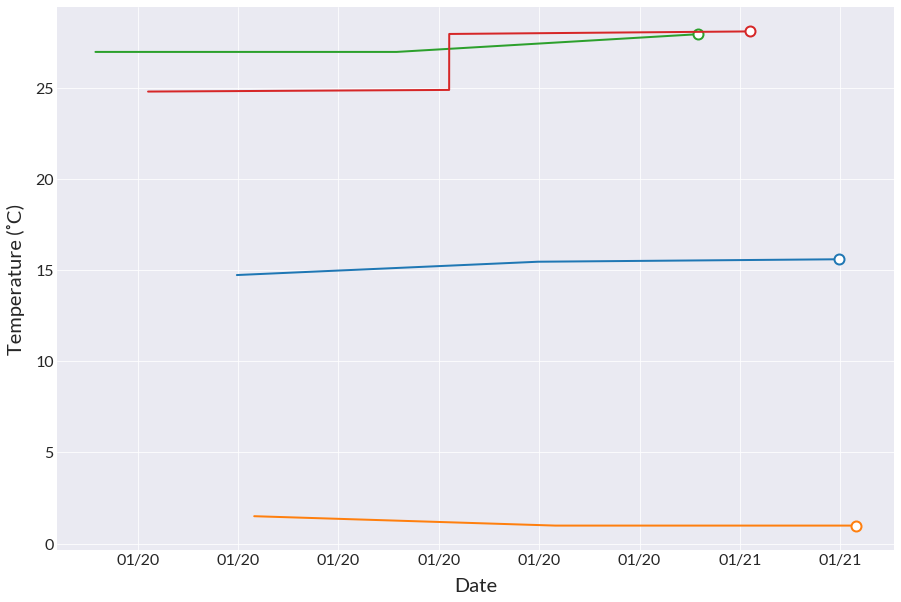

In [11]:
plt.style.use("seaborn-darkgrid")
plt.rcParams["font.family"] = "Lato"
plt.rcParams["font.size"] = 16
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

# Load DataFrame
df = pd.read_csv("weather_locations.csv")

# Convert date column to datetime
df.time_utc = df.time_utc.apply(lambda t: pd.to_datetime(str(t)))

# Plot Data
for city in cities.keys():
    df_temp = df[df["location"] == city].copy()
    ax.plot(df_temp["time_utc"], df_temp["temperature_c"], lw=2, markevery=[-1], marker="o", ms=10, mew=2, mfc="white")

# Tick Label Format
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))

# Axis Labels
ax.set_xlabel("Date", labelpad=10, size=20)
ax.set_ylabel("Temperature (˚C)", labelpad=10, size=20)

# ax.set_title(
#     "Extreme Weather Temperatures Worldwide\n" +
#     f"Most Recent: {df.iloc[-1].t_hot_f} ˚F (hot) and {df.iloc[-1].t_cold_f} ˚F (cold) @ {df.iloc[-1].date}", 
#     loc="left", pad=20
# )

plt.savefig("weather_locations.png", dpi=300, bbox_inches="tight")
plt.show()